# s-d model + tight binding model, cluster ansatz by Yordanov

## Calculation speed

1. 3 nodes, 3 electrons

   Single PC, Intel core i7

   __Yordanov ansatz: 1000 iteration, 110 sec__

   Even if I start with correct solution, it takes 55 sec to finish simulations. In a first iteration it jumps of the solution and then slowly returns back. Requires 15k cx gates.

    __"Classical" cluster ansatz: 1000 iterations, 325 sec__

   3 times longer than Yordanov ansatz, which is in agreement to 3 times longer quantum circuit for classical ansatz.

   __Problem agnostic short anzatz (2 layers of rotations and entagling) with particle conservation in the cost function: 1000 iterations, 15 sec__

   This ansatz is not reliable, does not give correct solution all the time. Depends on initial parameters values.

   __Using only single exciations in the anzats: 1000 iterations, 8 sec__

   Looks like using single excitations is enough to get any wave function. This is because single excitations are performed one after another and act on superposition states. Not clear why we need double excitations. Circuit depth at that is much shorter. It requires about 750 cx gates only.


## Dependence on the system size

Comment: test is performed with U>> J,t. Initial state is one of the AFM states minimizing the Coulomb energy. There is degeracy of the Coulomb energy. There are several states with the same energy. Combination of these state allows to minimize the kinetic energy as well. This is what VQE is doing in this test.

1. 2 nodes

   Gets correct ground state withn 3 seconds. cx: 30, 600 interations to get convergence

   2 nodes + 2 electrons, no periodic boundary conditions, J = 0. Exact solution: E_gs = -sqrt(U_c^2 + 2t^2).

   For U_c = 10 and t = 1 we get E_gs = -10.198. VQE with 6000 iterations gives -10.1. So, we get 1% precision. At 30k iterations we get -10.1977, 0.003% precision

3. 3 nodes

   40 secs for 3000 iterations. cx: 84, do not get convergence. Looks like better ground state can be achieved.

   Even with 12k iterations there is no convergence. However, the final state is very close to the ground state.

4. 4 nodes

   Cx: 170, 100 sec for 3000 iteration. No conversion. Even 12k  iteratoins (450 secs) is not enough to get the correct answer. Even 36k iteration is not enough for the convergence.
   

In [1]:
#Qiskit modules
import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp

#math modules
import math
import numpy as np

# SciPy minimizer routine
from scipy.optimize import minimize

import time

#My libraries
import vqe_funcs

In [2]:
PI = np.pi

## Here are the functions performing Jordan-Wigner transformation for fermionc Pauli operators and kinetci energy of electrons 

Important notes:

1) This is spin-depenedent version, so each node has spin-coordinate and is described by 2 qubits.

   Spin-up state for node i is described by qubit i.

   Spin-down state for node i is described by qubit i + N, where N is the nodes number.

In [3]:
from vqe_funcs import sigma_x, sigma_y, sigma_z, kinetic_energy, full_ham

## Magnetization distribution description

In [19]:
#Uniform magnetization along z axis
#nodes_number = 4
#mag = []

def uniform_z(nodes_number):
    mag = []
    for i in range(nodes_number):
        mag.append([0, 0, 1])
    return mag

## Full Hamiltonian

The Hamiltonian includes kinteic energy and s-d exchage energy

In [20]:
#nodes_number = 2
#mag = uniform_z(nodes_number)
#full_ham(nodes_number, mag, 4, 1, periodic = True)

vqe_funcs.Coulomb_on_site_ess(5, 2)

SparsePauliOp(['IIIIZIIIIZ', 'IIIZIIIIZI', 'IIZIIIIZII', 'IZIIIIZIII', 'ZIIIIZIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [6]:
# Anzatz from Yordanov paper including single and double FERMIONIC excitations.  Initial state is first n_el qubits are excited
def anzatz_qc(theta, nodes_number, electrons_number):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    for i in range(electrons_number):
        v_qc.x(i)
    v_qc = vqe_funcs.exc_yordanov(qubits_number, theta, v_qc)
    return v_qc

In [7]:
# Anzatz from Yordanov paper including single and double QUBITs excitations.  Initial state is first n_el qubits are excited
def anzatz_qc(theta, nodes_number, electrons_number):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    for i in range(electrons_number):
        v_qc.x(i)
    v_qc = vqe_funcs.exc_yordanov_no_stair(qubits_number, theta, v_qc)
    return v_qc

In [8]:
# Anzatz from Yordanov paper including only single QUBITs excitations. Initial state is first n_el qubits are excited
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    for i in range(qubits_number):
        if init_guess[i] == 1:
            v_qc.x(i)
    v_qc = vqe_funcs.exc_yordanov_single_only_no_ladder(qubits_number, theta, v_qc, n_red)
    return v_qc

In [35]:
# Anzatz from Yordanov paper including only single QUBITs excitations. Initial state is a combination of degenerate AFM states 
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    v_qc.h(0)
    for i in range(2 * nodes_number - 1):
        v_qc.cx(i, i + 1)
        
    for i in range(nodes_number):
        if i % 2 == 0:
            v_qc.x(i)
    for i in range(nodes_number, 2 * nodes_number):
        if (i - nodes_number) % 2 != 0:
            v_qc.x(i)
    
    v_qc = vqe_funcs.exc_yordanov_single_only_no_ladder(qubits_number, theta, v_qc, n_red)
    return v_qc

In [36]:
nodes_number = 3
electrons_number = 3
n_qubits = nodes_number * 2
len_se = n_qubits * (n_qubits - 1) / 2
len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
len_tot = int(len_se + len_de)

theta = [0]
for i in range(len_tot):
    theta.append(0)

theta[8] = 0
theta[4] = 0
theta[8] = 0

init_guess = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

qc = anzatz_qc(theta, nodes_number, electrons_number, 0, init_guess)


In [37]:
qc.decompose().count_ops()

OrderedDict([('cx', 92),
             ('r', 45),
             ('u1', 45),
             ('h', 24),
             ('u2', 16),
             ('u3', 3)])

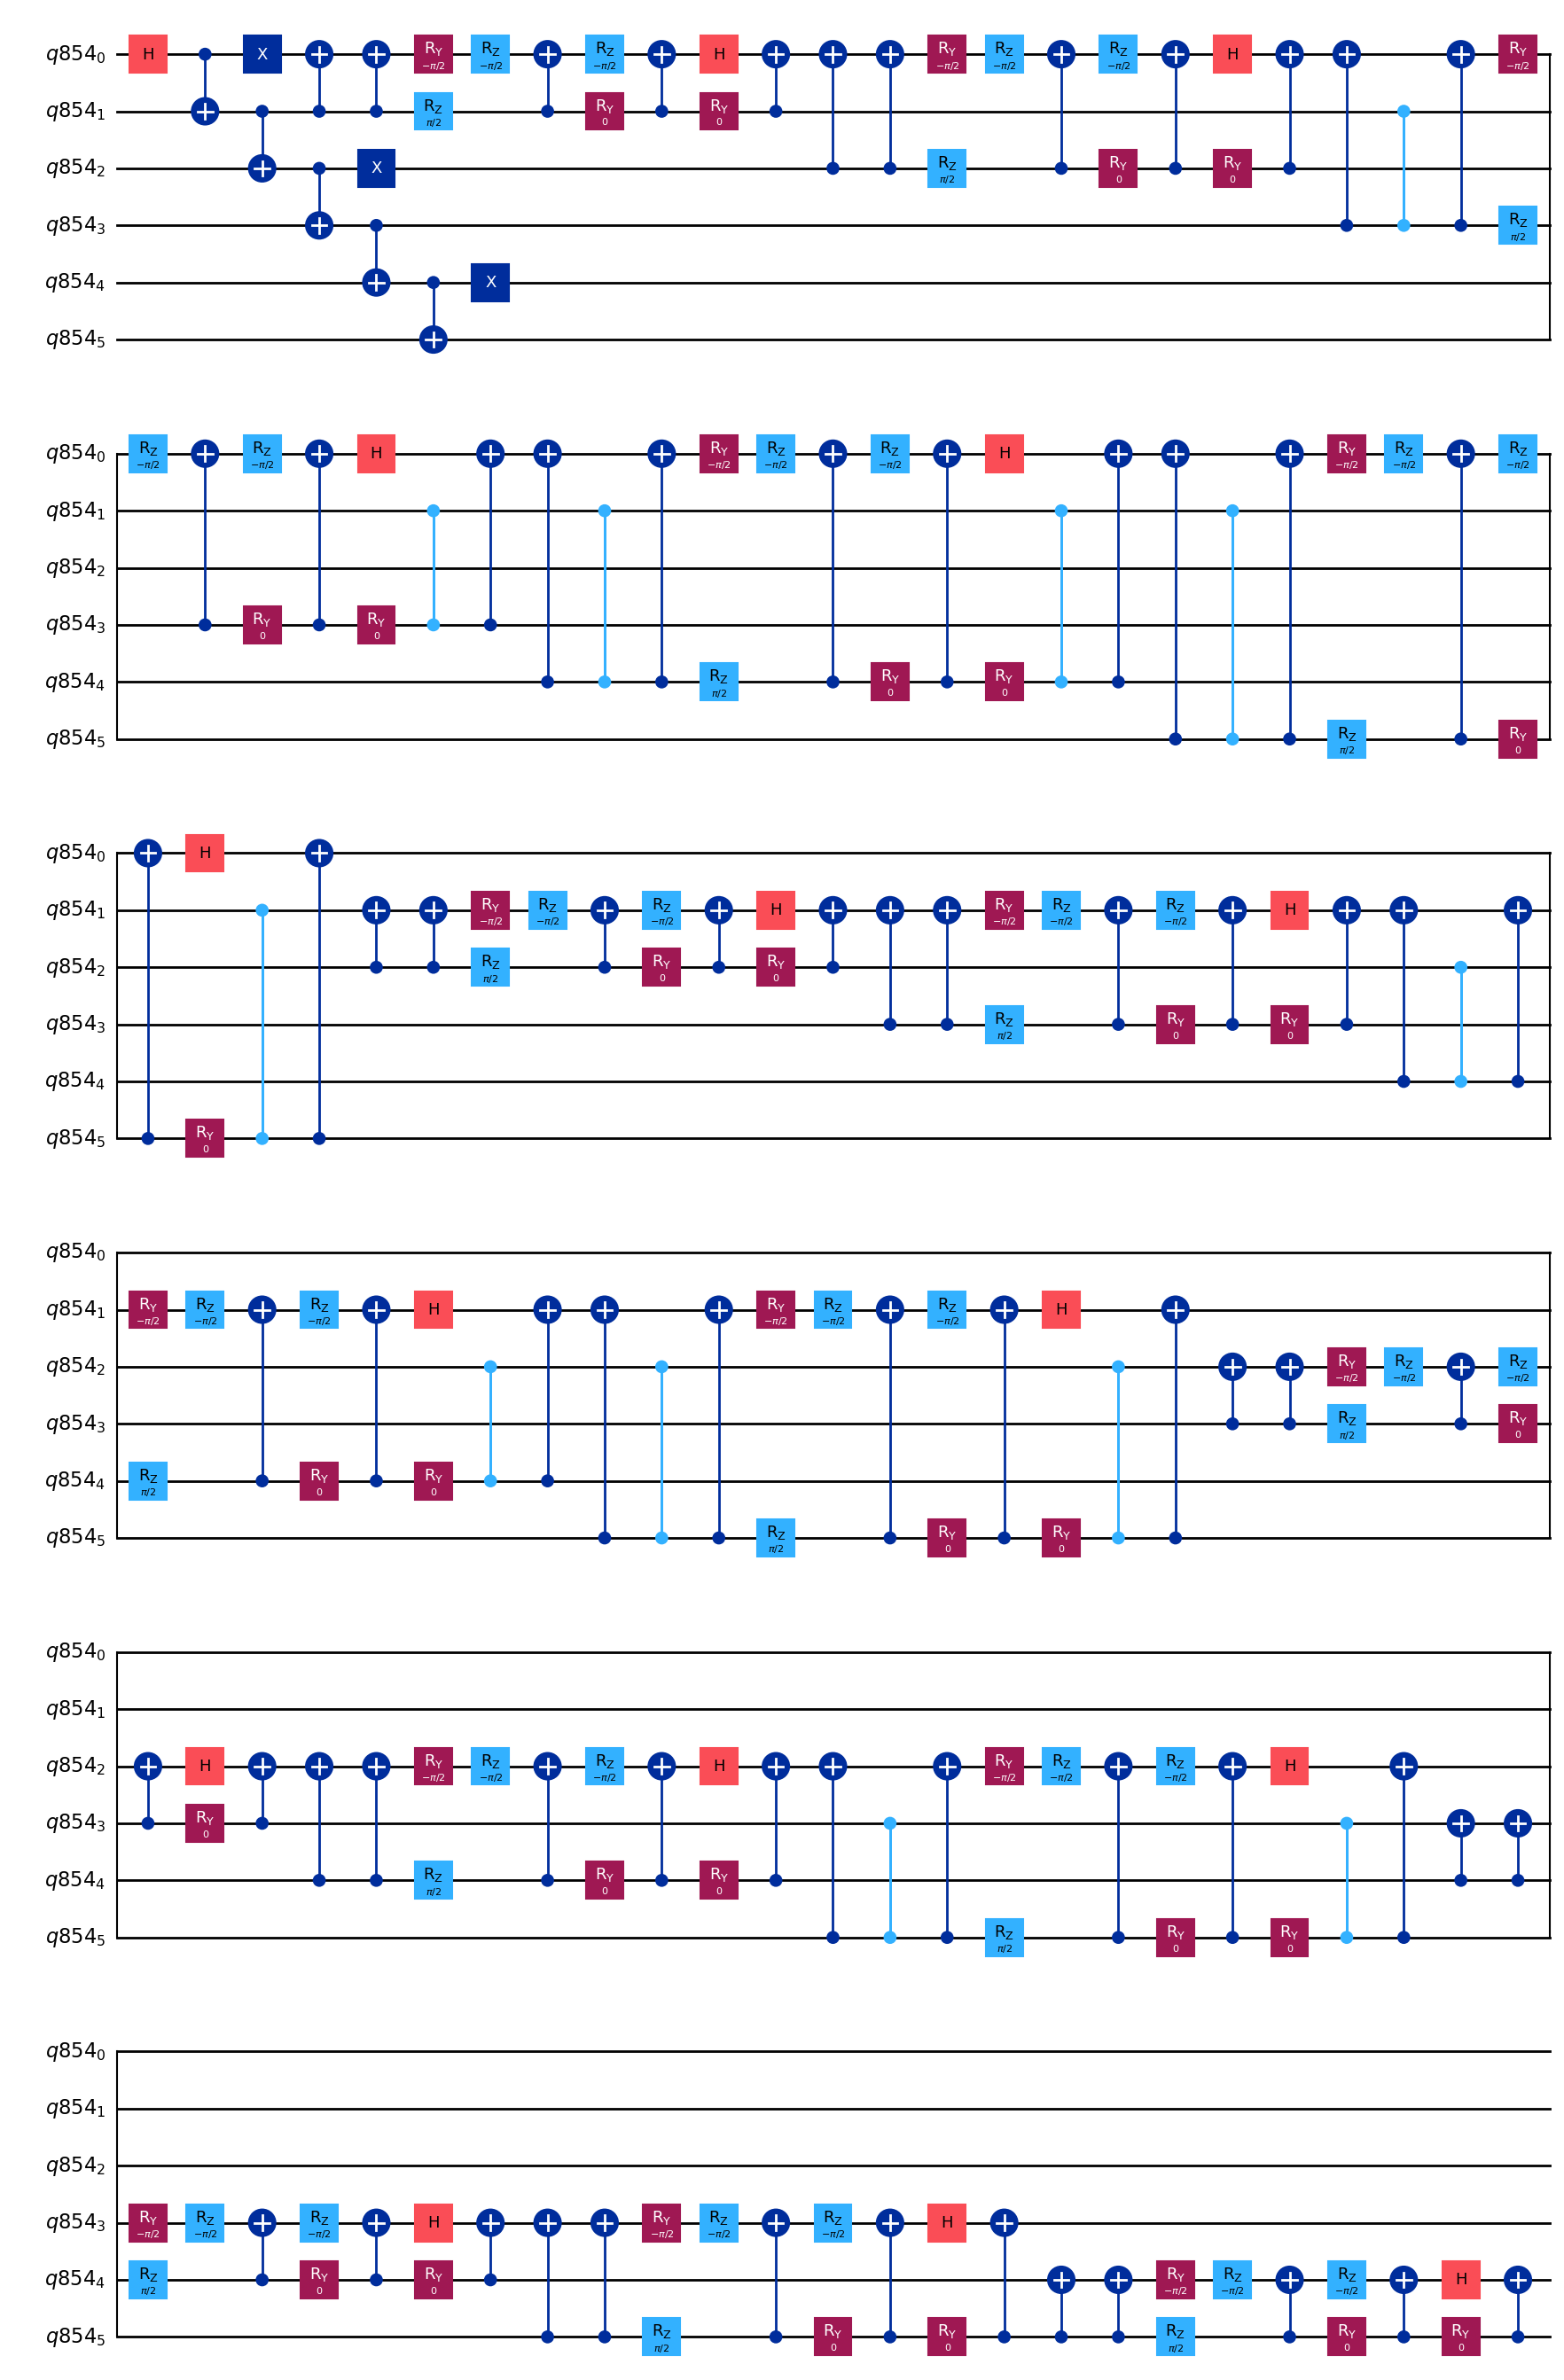

In [38]:
qc.draw('mpl')

In [39]:
nodes_number = 3
electrons_number = 3
n_red = 0
init_guess = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
q_r = Q_R(nodes_number * 2)
cl_r = C_R(nodes_number * 2)
qc_f = QuantumCircuit(q_r,cl_r)
qc_1 = anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess)
qc_f.append(qc_1, q_r)

#for i in range(bit_size):
#    qc_f.measure(i,i)
SimulatorAer = AerSimulator()

qc_f.save_statevector()

#qc_f.decompose().draw('mpl')

from qiskit.quantum_info import partial_trace, DensityMatrix
from qiskit.visualization import plot_state_city

circ = transpile(qc_f, backend = SimulatorAer)
result = SimulatorAer.run(circ,shots = 1).result()
ground_state = result.get_statevector(circ)

import sys
sys.path.insert(0, 'C:/Users/Oleg/Google Диск/QC/Codes/QC-qiskit-codes/Library')
import aux_func as af
n_nonzero = 0
n_states = pow(2, 2 * nodes_number)
states = []
prob = []
for i in range(n_states):
    pr = pow(abs(ground_state[i]), 2)
    if pr>0.000001: #0/n_states/2:
        n_nonzero = n_nonzero + 1
        states.append(i)
        prob.append(pr)
        print('state: ' + str(af.int_2_bin_word(i, 2 * nodes_number)) + ', prob: ' + str(pr) + ', complex amplitude: ' + str(ground_state[i]))
    
print('Energy: ' + str(res.fun))

state: 010101, prob: 0.5000000000000041, complex amplitude: (0.5000000000000013-0.5000000000000028j)
state: 101010, prob: 0.5000000000000041, complex amplitude: (0.5000000000000012-0.5000000000000029j)
Energy: -10.198035977844217


In [45]:
# defining a cost function
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim(theta, nodes_number, hamiltonian, electrons_number, n_red, init_guess):
    v_qc = anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess)
    
    estimator = StatevectorEstimator()
    job = estimator.run([(v_qc, hamiltonian)])
    estimator_expvals = job.result()[0].data.evs
    
      
    #print 
    #print('iter: ' + str( cost_history_dict["iters"]) + ', Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals

In [41]:
nodes_number = 3
electrons_number = 3
n_qubits = nodes_number * 2
len_se = n_qubits * (n_qubits - 1) / 2
len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
len_tot = int(len_se + len_de)

theta = [0]
for i in range(len_tot):
    theta.append(0)

#theta[0] = PI / 9
#theta[4] = PI / 9

init_guess = [1, 0, 0, 1]
J = 0.00 #s-d exchange constant
t = 2 #hopping matrix element (kinetic energy coefficient)
electrons_number = 4
n_red = 0
U_c = 10
hamiltonian = full_ham(nodes_number, mag, J, t, U_c, periodic = True)
estim(theta, nodes_number, hamiltonian, electrons_number, 0, init_guess)

IndexError: list index out of range

In [60]:
# Hamiltonian parameters
nodes_number = 3 #number of nodes
n_qubits = nodes_number * 3
J = 0.00 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
electrons_number = 3
n_red = 0
U_c = 10

#Cost history initialization
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

import random
num = random.random()
#print(num)


mag = []
mag = uniform_z(nodes_number)

#initialize the state
len_se = n_qubits * (n_qubits - 1) / 2
len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
len_tot = int(len_se)
x0 = []
for i in range(len_tot):
    #x0.append(0)
    x0.append(random.random() * 0.00)

#initial guess for the solution
init_guess = [1, 0, 0, 1]

#define the Hamiltonian
hamiltonian = full_ham(nodes_number, mag, J, t, U_c, periodic = False)
#print(hamiltonian)
#Optimization
start = time.time()
res = minimize(
        estim,
        x0,
        args=(nodes_number , hamiltonian, electrons_number, n_red, init_guess),
        method="cobyla",
        options={"maxiter":  200000} #, "rhobeg": 1
    )
end = time.time()
print(['time elapsed: ' + str(end - start) + ' sec'])
#print(res)
#print(cost_history_dict)

['time elapsed: 53297.053622722626 sec']


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -15.258278472886737
       x: [-9.192e-01  3.165e+00 ...  1.166e-01 -2.038e-02]
    nfev: 100000
   maxcv: 0.0


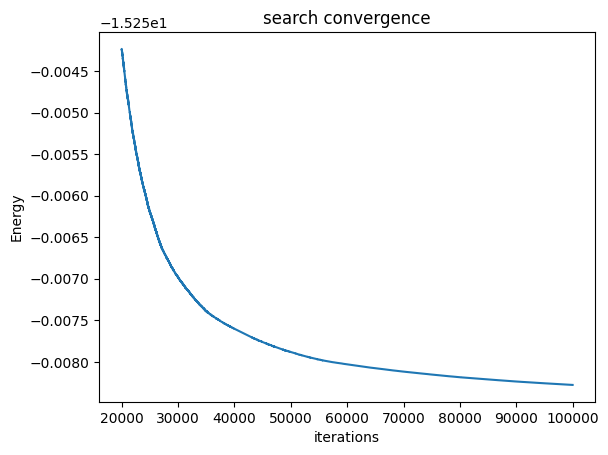

In [55]:
import matplotlib.pyplot as plt
print(res)
en = cost_history_dict["cost_history"]
iterations = range(len(en))
# Create the plot
plt.plot(iterations[20000:100000], en[20000:100000])

# Add labels and title
plt.xlabel('iterations')
plt.ylabel('Energy')
plt.title('search convergence')

# Display the plot
plt.show()

In [59]:
q_r = Q_R(nodes_number * 2)
cl_r = C_R(nodes_number * 2)
qc_f = QuantumCircuit(q_r,cl_r)
qc_1 = anzatz_qc(res.x, nodes_number, electrons_number, n_red, init_guess)
qc_f.append(qc_1, q_r)

#for i in range(bit_size):
#    qc_f.measure(i,i)
SimulatorAer = AerSimulator()

qc_f.save_statevector()

#qc_f.decompose().draw('mpl')

from qiskit.quantum_info import partial_trace, DensityMatrix
from qiskit.visualization import plot_state_city

circ = transpile(qc_f, backend = SimulatorAer)
result = SimulatorAer.run(circ,shots = 1).result()
ground_state = result.get_statevector(circ)

import sys
sys.path.insert(0, 'C:/Users/Oleg/Google Диск/QC/Codes/QC-qiskit-codes/Library')
import aux_func as af
n_nonzero = 0
n_states = pow(2, 2 * nodes_number)
states = []
prob = []
for i in range(n_states):
    pr = pow(abs(ground_state[i]), 2)
    if pr>0.01: #0/n_states/2:
        n_nonzero = n_nonzero + 1
        states.append(i)
        prob.append(pr)
        print('state: ' + str(af.int_2_bin_word(i, 2 * nodes_number)) + ', prob: ' + str(pr) + ', complex amplitude: ' + str(ground_state[i]))
    
print('Energy: ' + str(res.fun))

state: 001110, prob: 0.15302922479055642, complex amplitude: (0.27661274807079667-0.2766127480707973j)
state: 010101, prob: 0.36153597879332333, complex amplitude: (0.42516818953992913-0.42516818953993046j)
state: 101010, prob: 0.33956548484235527, complex amplitude: (0.41204701481891265-0.4120470148189136j)
state: 110001, prob: 0.1317367941188043, complex amplitude: (0.2566483918893746-0.25664839188937516j)
Energy: -15.258278472886737


In [188]:
#qc_f.decompose().count_ops()